# Compute friends graph

We will use get request to api.vk.com and friends.get in order to build friends graph. 

In [2]:
import requests
import networkx
import matplotlib.pyplot as plt
import time
import collections
%matplotlib inline

Define functions for making responses to VK server. Functions return lists of ID's and ID's + city, name, sex.

In [3]:
def get_friends_ids(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}&fields=sex,city&v=5.52'
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('error'):
        print json_response.get('error')
        return list()
    return json_response[u'response'][u'items']

def get_mutuals(user_id):
    friends_url = 'https://api.vk.com/method/friends.get?user_id={}'
    json_response = requests.get(friends_url.format(user_id)).json()
    if json_response.get('error'):
        return list()
    return json_response[u'response']

Here mutuals is a key-value dictionary with the following structure: key is an ID of one of the friends returned by get_friends_ids function and value contains list of all mutual friends of this key ID with the initial user_id passed into get_friends_ids arguments list.

In [4]:
myids = get_friends_ids(8943258)

foff = {}
for friend in myids:
    foff[friend[u'id']] = get_mutuals(friend[u'id'])

Then create a networkX graph object and populate it with nodes and edges. Edges connect friends through mutual friends.

In [10]:
g = networkx.Graph(directed=False)

for i in myids:
    try:
        g.add_node(i[u'id'], first_name=i[u'first_name'], last_name=i[u'last_name'],
                   city=i[u'city'][u'title'], sex=i[u'sex'])
    except:
        
        g.add_node(i[u'id'], first_name=i[u'first_name'], last_name=i[u'last_name'],
                   city='Hidden', sex=i[u'sex'])
    for j in foff[i[u'id']]:
        if i[u'id'] != j and i[u'id'] in foff and j in foff:
            g.add_edge(i[u'id'], j)
# networkx.write_gml(g, 'friendsvk.gml')

Draw the graph via networkX and matplotlib.

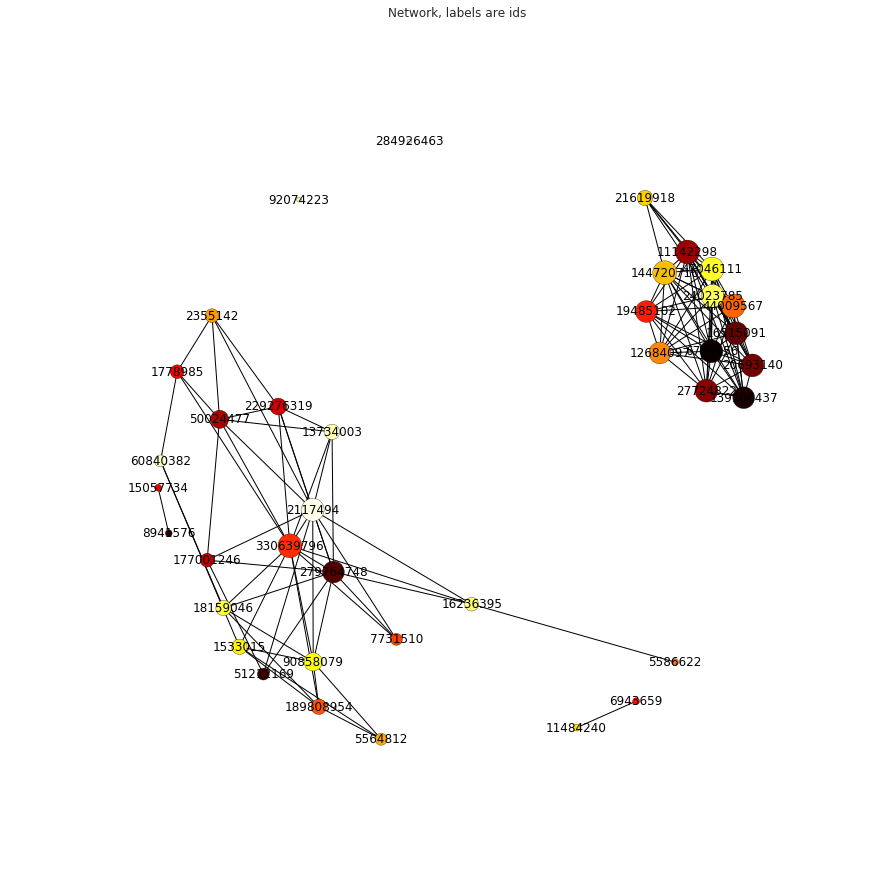

In [75]:
from math import *
sizes = []
nodes = g.nodes()
for node in nodes:
    if len(g.neighbors(node)) > 0:
        sizes.append(len(g.neighbors(node))*1800./len(nodes))
    else:
        sizes.append(20)
pos = networkx.fruchterman_reingold_layout(g)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.title('Network, labels are ids')
networkx.draw_networkx(g, pos, node_size=sizes, node_color=range(len(myids)), cmap = plt.cm.hot, with_labels=range(38), width=1)
plt.show()

# 1 Network summary

### 1.1 First of all, graph summary, size and order

In [7]:
print networkx.info(g)

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 122
Average degree:   6.4211


### 1.2 Attributes: city, sex, first name, last name and id

In [5]:
for key in g.node.keys():
    print ('id: %s, city: %s, first name: %s, last name: %s, sex(1=female/2=male): %s' %
           (key, g.node[key]['city'].encode('utf8'), g.node[key]['first_name'].encode('utf8'), g.node[key]['last_name'].encode('utf8'), g.node[key]['sex']))

id: 6729856, city: Москва, first name: Дмитрий, last name: Денисов, sex(1=female/2=male): 2
id: 139106437, city: Москва, first name: Роман, last name: Бурмистров, sex(1=female/2=male): 2
id: 8941576, city: Мурманск, first name: Владимир, last name: Никитин, sex(1=female/2=male): 2
id: 51212169, city: Москва, first name: Настя, last name: Бочкова, sex(1=female/2=male): 1
id: 279764748, city: Hidden, first name: Катя, last name: Море, sex(1=female/2=male): 1
id: 16515091, city: Hidden, first name: Анастасия, last name: Коньшина, sex(1=female/2=male): 1
id: 20693140, city: Москва, first name: Дима, last name: Васькин, sex(1=female/2=male): 2
id: 27724822, city: Нижний Новгород, first name: Сергей, last name: Кузнецов, sex(1=female/2=male): 2
id: 11142298, city: Москва, first name: Ира, last name: Степанюк, sex(1=female/2=male): 1
id: 50024477, city: Hidden, first name: Маша, last name: Лень, sex(1=female/2=male): 2
id: 177001246, city: Москва, first name: Константин, last name: Брю, sex(1

### 1.3 Degree distribution:

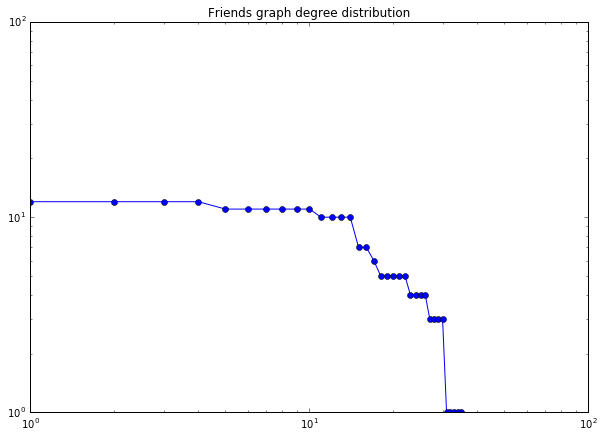

In [47]:
degreeseq=sorted(networkx.degree(g).values(),reverse=True) 
plt.figure(figsize=(10,7))
plt.loglog(degreeseq, marker='o')
plt.title('Friends graph degree distribution')
plt.show()

### 1.4 Shortest paths distrubution

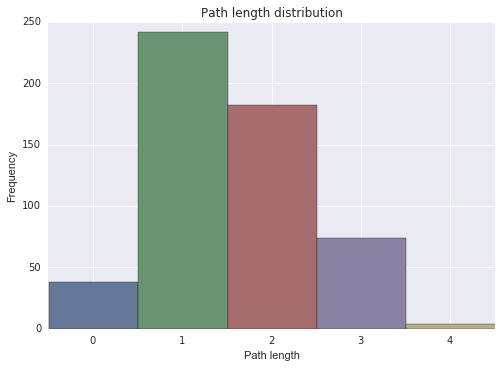

In [106]:
import numpy as np
import seaborn as sns
lengths = networkx.shortest_path_length(g)
paths_lengths = []
for k in lengths.keys():
    for k1 in lengths[k].keys():
        paths_lengths.append(lengths[k][k1])

c = collections.Counter()
for length in paths_lengths:
    c[length] += 1

colors = []
for i in range(len(c.keys())):
    colors.append(tuple((float(np.random.uniform(0,1,1)),float(np.random.uniform(0,1,1)),float(np.random.uniform(0,1,1)))))  
plt.bar(map(lambda x: x-0.49, c.keys()), c.values(), width=1, color = sns.color_palette("deep", len(c.keys()), desat=0.5))
plt.xlabel('Path length')
plt.ylabel('Frequency')
plt.xlim(-0.5, 4.5)
plt.title('Path length distribution')
plt.show()

### 1.5 Diameter, radius and clustering coefficients distributions are as follows

Global clustering coefficient is 0.594926710716


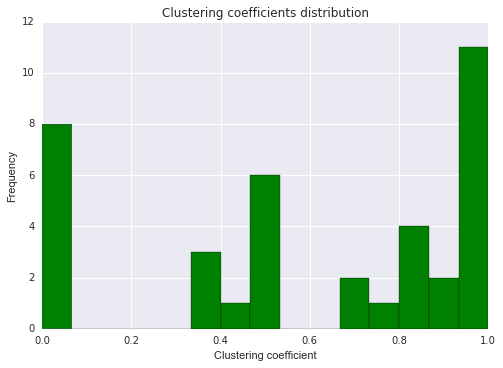

In [90]:
clustcoef = networkx.clustering(g)
# networkx.diameter(g)
# networkx.radius(g)
countedcoefs = collections.Counter()
globalcoef = 0
for key in clustcoef.keys():
    countedcoefs[clustcoef[key]] += 1
    globalcoef += clustcoef[key]
globalcoef = globalcoef/len(clustcoef.keys())
print ('Global clustering coefficient is %s' % globalcoef)
plt.hist(clustcoef.values(), bins=len(countedcoefs.keys()), color='g')
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.title('Clustering coefficients distribution')
plt.show()

Diameter

In [1]:
import igraph
gr = igraph.Graph.Read_GML('/Users/oneinchman/Desktop/untitled1/friendsvk.gml')
print ('Diameter is: %s' % gr.diameter(directed=False))

Diameter is: 4


# 2 Structural analysis

### 2.1 Degree, closeness and betweenness centralities

Let's define a function that returns any centrality we want

In [77]:
def get_centrality_vals(func, graph):
    dic = func(graph)
    centralityVals = []
    for key in dic.keys():
        centralityVals.append(dic[key])
    return centralityVals

Use it to get centralities

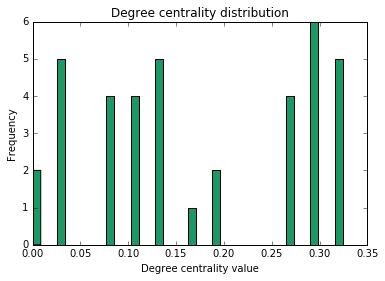

In [78]:
degcentr = get_centrality_vals(networkx.degree_centrality, g)
plt.hist(degcentr, bins=len(degcentr), color=(0.1, 0.6, 0.4))
plt.xlabel('Degree centrality value')
plt.ylabel('Frequency')
plt.title('Degree centrality distribution')
plt.show()
 

##### Graph with corresponding node sizes and colors

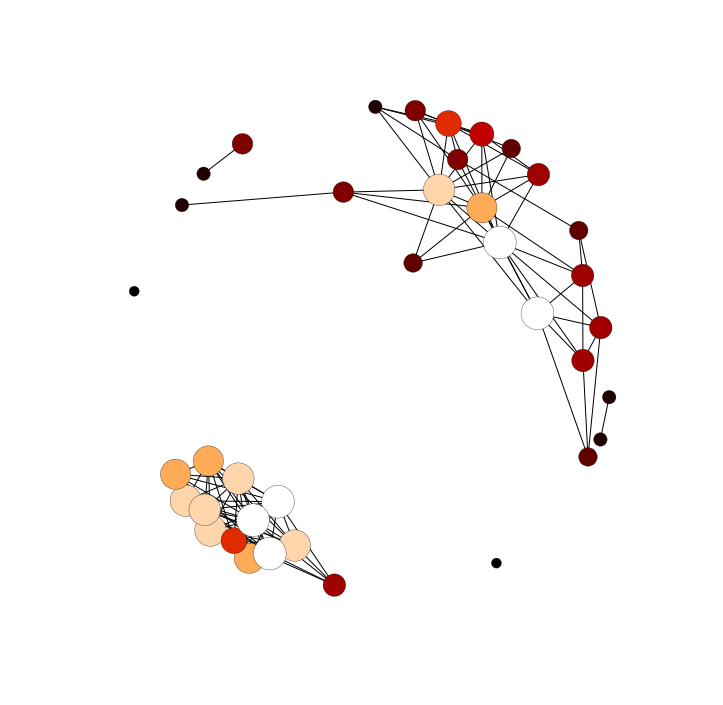

In [94]:
import seaborn as sns
tmp = networkx.degree_centrality(g)
sz = []
for key in tmp.keys():
    sz.append(tmp[key]*3000 + 100)

pos = networkx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12,12))
plt.axis('off')
networkx.draw_networkx(g, pos, node_size=sz, with_labels=False, width=1,
                       node_color =tmp.values(), cmap = plt.cm.gist_heat)
plt.show()

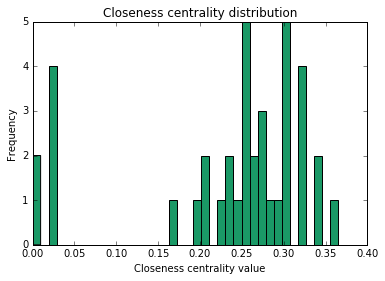

In [79]:
closecentr = get_centrality_vals(networkx.closeness_centrality, g)
plt.hist(closecentr, bins=len(closecentr), color=(0.1, 0.6, 0.4))
plt.xlabel('Closeness centrality value')
plt.ylabel('Frequency')
plt.title('Closeness centrality distribution')
plt.show()

##### Graph with corresponding node sizes and colors

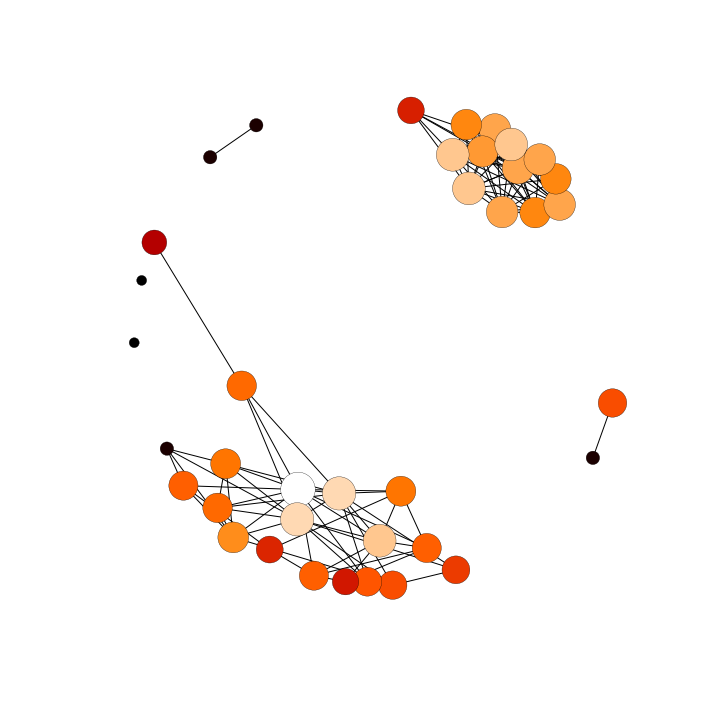

In [95]:
import seaborn as sns
tmp = networkx.closeness_centrality(g)
sz = []
for key in tmp.keys():
    sz.append(tmp[key]*3000 + 100)

pos = networkx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12,12))
plt.axis('off')
networkx.draw_networkx(g, pos, node_size=sz, with_labels=False, width=1,
                       node_color = tmp.values(), cmap = plt.cm.gist_heat)
plt.show()

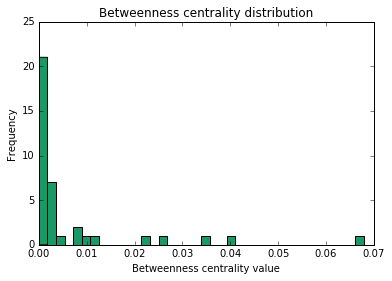

In [80]:
betwcentr = get_centrality_vals(networkx.betweenness_centrality, g)
plt.hist(betwcentr, bins=len(betwcentr), color=(0.1, 0.6, 0.4))
plt.xlabel('Betweenness centrality value')
plt.ylabel('Frequency')
plt.title('Betweenness centrality distribution')
plt.show()

##### Graph with corresponding node sizes and colors

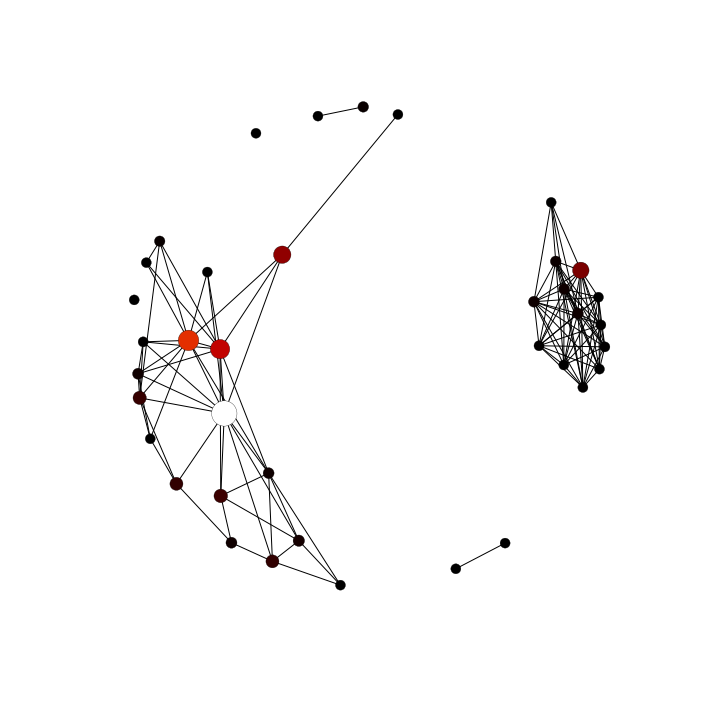

In [99]:
import seaborn as sns
tmp = networkx.betweenness_centrality(g)
sz = []
for key in tmp.keys():
    sz.append(tmp[key]*8000 + 100)

pos = networkx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12,12))
plt.axis('off')
networkx.draw_networkx(g, pos, node_size=sz, with_labels=False, width=1,
                       node_color =tmp.values(), cmap = plt.cm.gist_heat)
plt.show()

### 2.2 PageRank

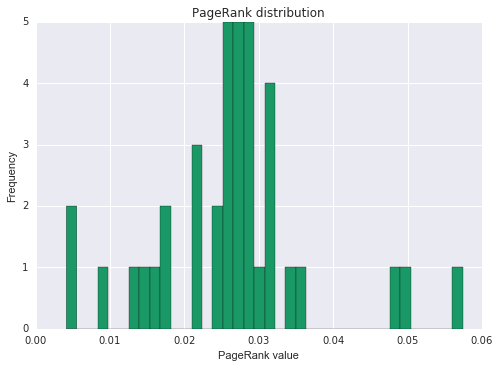

In [108]:
pagerank = get_centrality_vals(networkx.pagerank, g)
plt.hist(pagerank, bins=len(betwcentr), color=(0.1, 0.6, 0.4))
plt.xlabel('PageRank value')
plt.ylabel('Frequency')
plt.title('PageRank distribution')
plt.show()

##### Graph with corresponding node sizes and colors

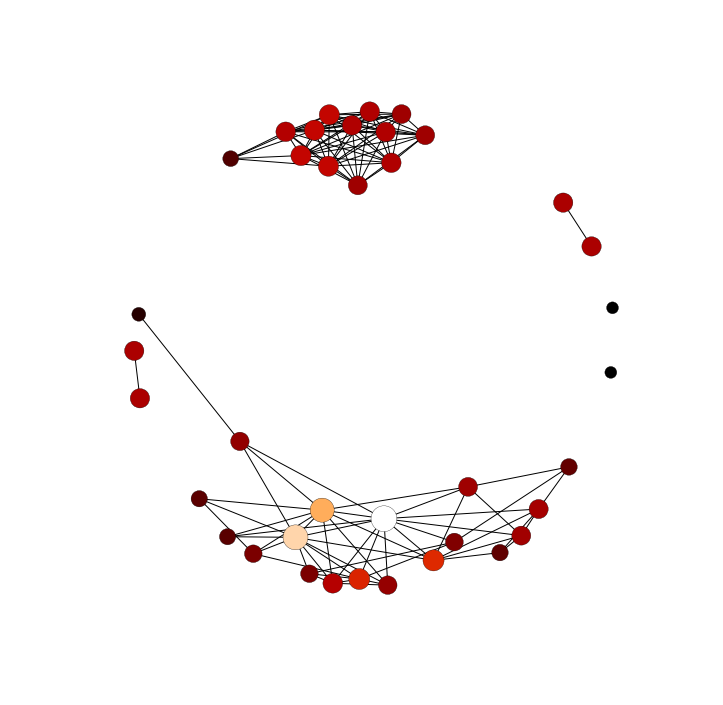

In [104]:
import seaborn as sns
tmp = networkx.pagerank(g)
sz = []
for key in tmp.keys():
    sz.append(tmp[key]*10000 + 100)

pos = networkx.fruchterman_reingold_layout(g)
plt.figure(figsize=(12,12))
plt.axis('off')
networkx.draw_networkx(g, pos, node_size=sz, with_labels=False, width=1,
                       node_color = tmp.values(), cmap = plt.cm.gist_heat)
plt.show()

It seems that distributions of all those metrics are pretty much the same and the most whitest nodes (meaning the nodes that have the biggest values) are on the same spot.

### 2.3 The closest random graph model similar to given network

##### It turns out, that random_partition_graph with 6 components and probability for those components to be connected being equal to 0.001 returns a graph that looks almost the same as network, downloaded via vk api. Below is generation routine and generated graph itself.

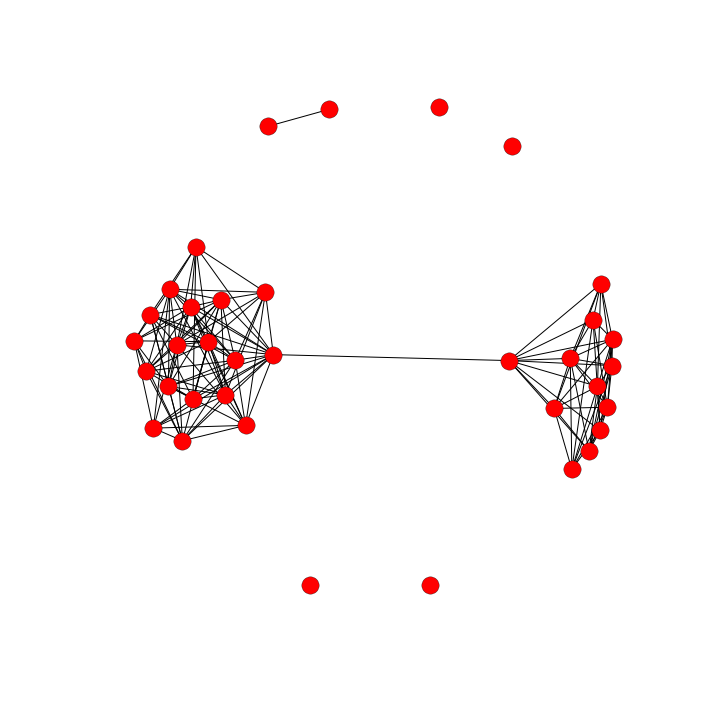

In [52]:
import networkx as nx
# rand = nx.caveman_graph(2, 10)
# rand = nx.relaxed_caveman_graph(2, 10, 0.02, seed=None)
rand = nx.random_partition_graph([12, 18, 2, 2, 1, 1], 0.7, 0.001, seed=None, directed=False)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(rand, pos = nx.fruchterman_reingold_layout(rand), with_labels=False)

### 2.4 Nodes similarity

Let's calculate jaccard node similarity and plot simlarity values on a $node_i$ X $node_j$ grid. It can be seen from the surface plot, that there are groups of very similar nodes with really high values of similarity and groups of nodes with exactly zero similarity which seems reasonable given the picture of the graph with a couple of rather isolated yet meaningful components.

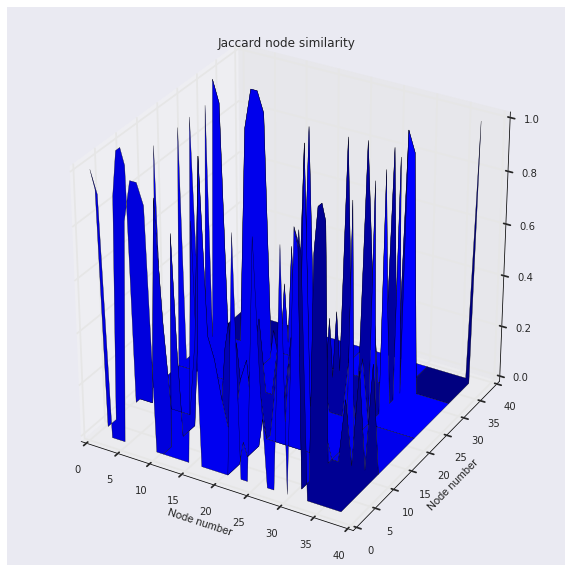

In [33]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
Z = gr.similarity_jaccard()
X = np.arange(1, 39)
Y = np.arange(1, 39)
x, y = np.meshgrid(X,Y)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,Z)
plt.xlabel('Node number')
plt.ylabel('Node number')
plt.title('Jaccard node similarity')
plt.show()

# 3 Community detection

### 3.1 All cliques with a total of 27 cliques

In [110]:
for elem in list(nx.find_cliques(g)):
    print ('Clique: %s' % elem)
print ('Total cliques: %s' % len(list(nx.find_cliques(g))))

Clique: [8941576, 15057734]
Clique: [51212169, 279764748, 2117494, 177001246]
Clique: [279764748, 2117494, 330639796, 90858079]
Clique: [279764748, 2117494, 330639796, 16236395]
Clique: [279764748, 2117494, 330639796, 7731510]
Clique: [279764748, 2117494, 330639796, 229276319, 13734003]
Clique: [279764748, 18159046, 330639796, 90858079]
Clique: [11142298, 144720716, 47046111, 44009567, 6729856, 24023785, 20693140, 27724822, 12684097, 16515091]
Clique: [11142298, 144720716, 47046111, 44009567, 6729856, 24023785, 20693140, 27724822, 12684097, 19485102]
Clique: [11142298, 144720716, 47046111, 44009567, 6729856, 24023785, 20693140, 27724822, 139106437, 16515091]
Clique: [11142298, 144720716, 47046111, 44009567, 6729856, 24023785, 20693140, 27724822, 139106437, 19485102]
Clique: [11142298, 144720716, 47046111, 44009567, 21619918, 16515091]
Clique: [50024477, 1778985, 330639796]
Clique: [50024477, 1778985, 2355142]
Clique: [50024477, 2117494, 177001246]
Clique: [50024477, 2117494, 229276319,

Load the graph again

In [105]:
from graph_tool.all import *
gtg = load_graph('/Users/oneinchman/Desktop/untitled1/friendsvk.gml')

### 3.2 K-cores

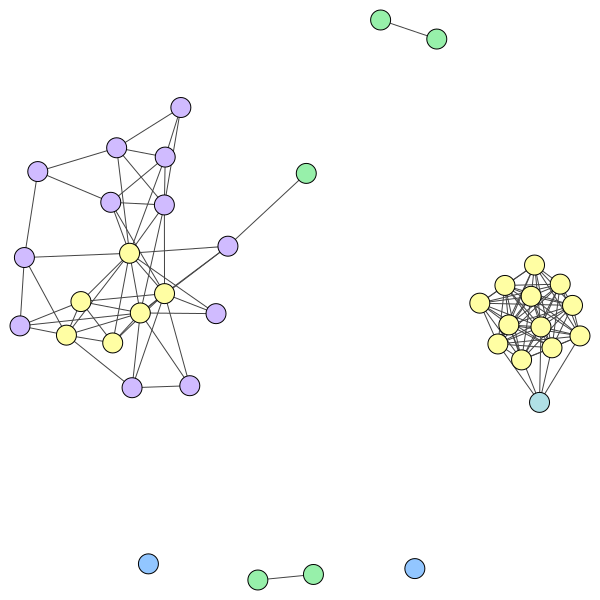

In [34]:
import seaborn as sns
core = igraph.Graph.coreness(gr)
color_list = sns.color_palette("pastel", len(core))
igraph.plot(gr, vertex_color=[color_list[x] for x in core], vertex_label=None)

### 3.3 Different community detection algorithms

Minimize blockmodel from graph-tool, 2 communities

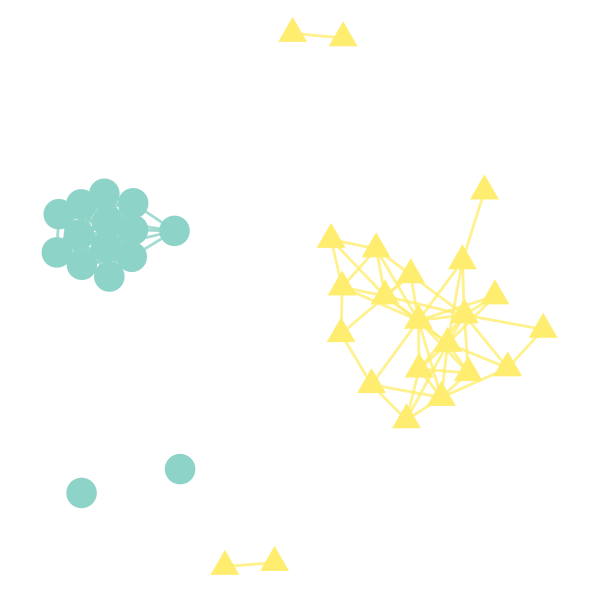

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042fb690, at 0x11bf2e710>

In [7]:
from graph_tool.all import minimize_blockmodel_dl
state = minimize_blockmodel_dl(gtg)
state.draw(vertex_shape=state.get_blocks())

EM block state from graph-tool with supposed number of groups equal to 3

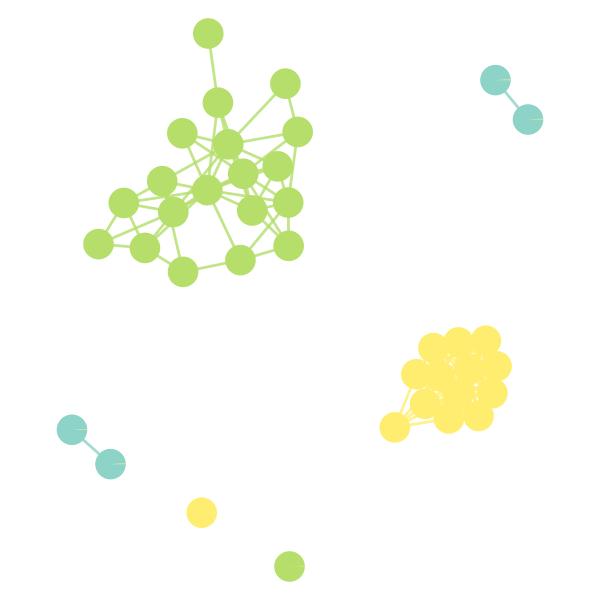

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1042fb690, at 0x11bf343d0>

In [17]:
from graph_tool.all import *
state = EMBlockState(gtg, B=3)
delta, niter = em_infer(state)
state.draw()

Best partition from community library for networkx, 7 groups

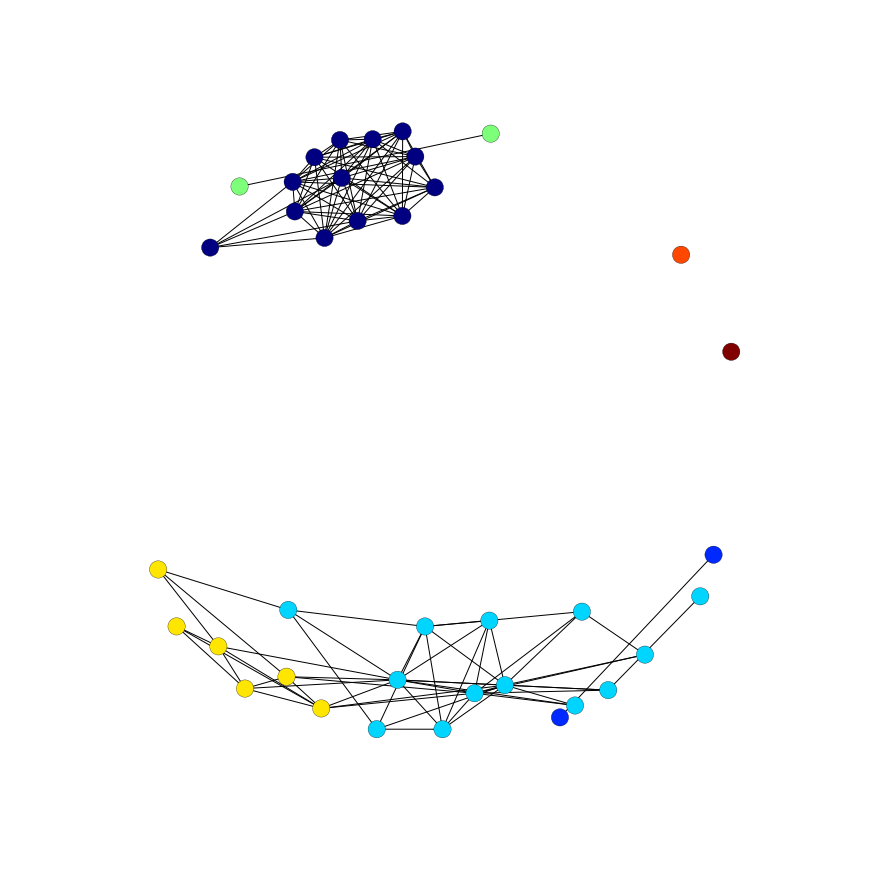

In [108]:
import community
import networkx as nx
parts = community.best_partition(g)
values = [parts.get(node) for node in g.nodes()]
plt.figure(figsize=(15,15))
plt.axis("off")
nx.draw_networkx(g, cmap = plt.get_cmap("jet"), node_color = values, node_size = 300, with_labels = False)

2 blocks via graph-tool's blockmodel

/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:623: UserWarning: Unknown parameter: layout_callback
  warnings.warn("Unknown parameter: " + k, UserWarning)
/usr/local/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:623: UserWarning: Unknown parameter: key_press_callback
  warnings.warn("Unknown parameter: " + k, UserWarning)


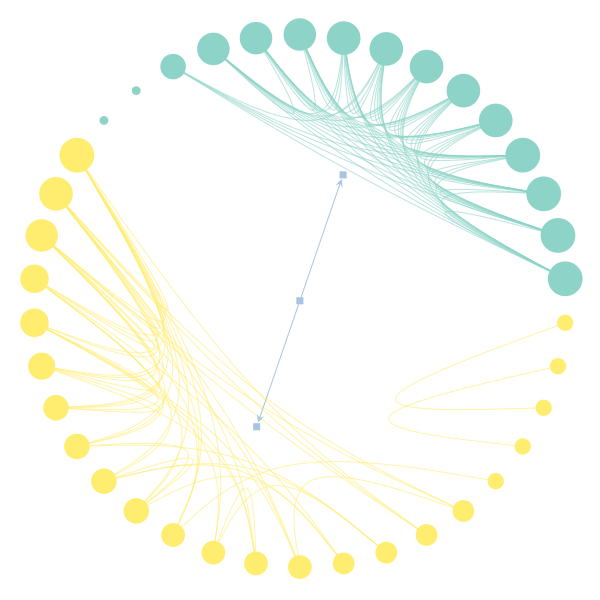

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x120de7150, at 0x10a2157d0>,
 <Graph object, directed, with 41 vertices and 40 edges at 0x10a1f27d0>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x10a1f27d0, at 0x10a202490>)

In [114]:
state = minimize_nested_blockmodel_dl(gtg, deg_corr=True)
state.draw()

Community walktrap by igraph, 6 communities

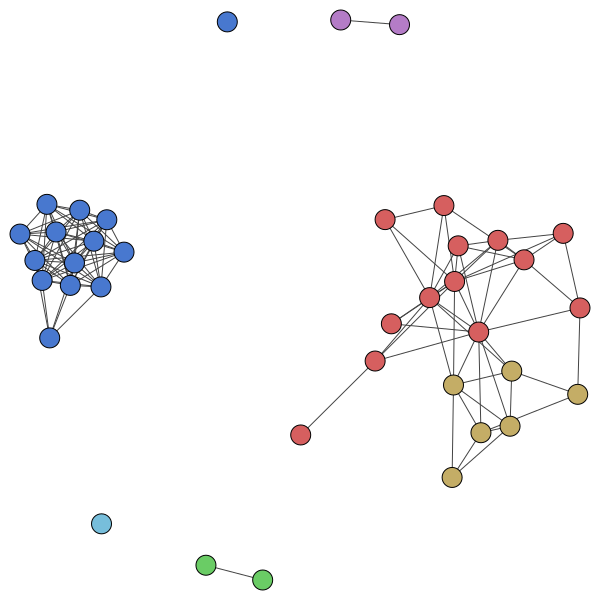

In [1]:
import igraph
import seaborn as sns
gr = igraph.Graph.Read_GML('/Users/oneinchman/Desktop/untitled1/friendsvk.gml')
walktrap = igraph.Graph.community_walktrap(gr)

color_list = sns.color_palette('muted', len(walktrap.as_clustering().membership))
igraph.plot(gr, vertex_color=[color_list[x] for x in walktrap.as_clustering().membership], vertex_label=None)

Fastgreedy by igraph, 6 communities

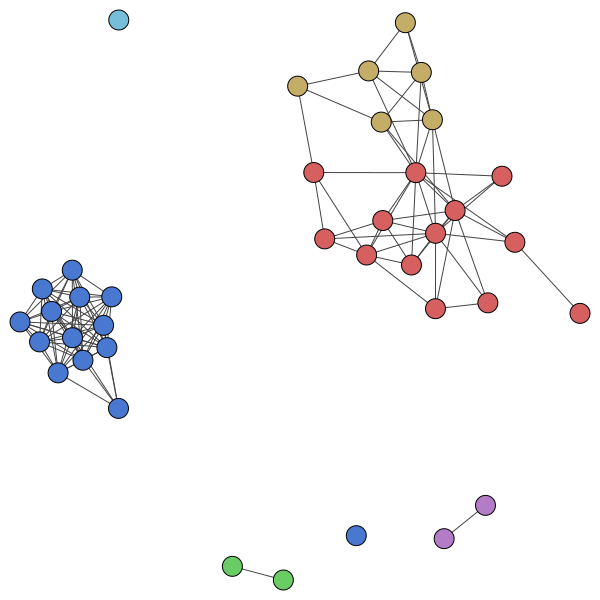

In [2]:
import igraph
import seaborn as sns
gr = igraph.Graph.Read_GML('/Users/oneinchman/Desktop/untitled1/friendsvk.gml')
dendro = igraph.Graph.community_fastgreedy(gr)
clust = dendro.as_clustering()

color_list = sns.color_palette('muted', len(clust.membership))
igraph.plot(gr, vertex_color=[color_list[x] for x in clust.membership], vertex_label=None)

Judging from the results above, it appears that algorithms that are not trying to critically minimize the number of communities estimate 6-7 communities on average, whereas the others tend to dump isolated nodes into one of the bigger communities, which is not correct since those are people with no connections with those communities. The results of igraph algorithms are pretty much the same.